In [21]:
from __future__ import annotations
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import pickle
import gymnasium as gym

env = gym.make("Acrobot-v1")

In [22]:
cost1_space = np.linspace(-1, 1, 3)
sint1_space = np.linspace(-1, 1, 3)
cost2_space = np.linspace(-1, 1, 3)
sint2_space = np.linspace(-1, 1, 3)
wt1_space = np.linspace(-12, 12, 3)
wt2_space = np.linspace(-28, 28, 3)

class ModelBenchmarkingAcrobotAgent:
    def __init__(
        self,
        model: np.ndarray[np.float64],
    ):
        self.actions = list(range(env.action_space.n))
        self.model = model

    

    def get_state(self, obs):
        cost1, sint1, cost2, sint2, wt1, wt2 = obs
        cost1_bin = np.digitize(cost1, cost1_space)
        sint1_bin = np.digitize(sint1, sint1_space)
        cost2_bin = np.digitize(cost2, cost2_space)
        sint2_bin = np.digitize(sint2, sint2_space)
        wt1_bin = np.digitize(wt1, wt1_space)
        wt2_bin = np.digitize(wt2, wt2_space)
        return (cost1_bin, sint1_bin, cost2_bin, sint2_bin, wt1_bin, wt2_bin)

    def get_action(self, obs):
        state = self.get_state(obs)
        return int(np.argmax(self.model[state]))

In [23]:
file = open("4lr.pkl", "rb")
model = pickle.load(file)
file.close()
agent = ModelBenchmarkingAcrobotAgent(
    model=model
)
n_episodes = 1000
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        obs = next_obs

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 153.54it/s]


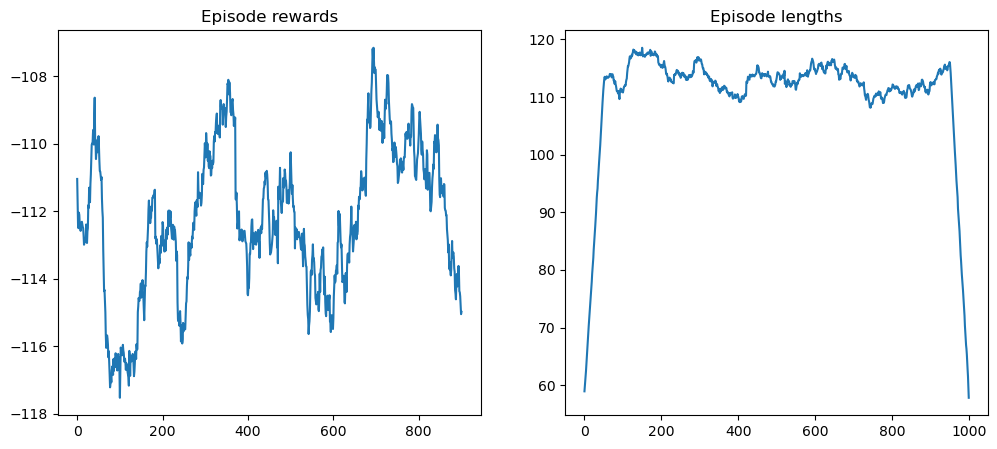

In [24]:
rolling_length = 100
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)